# Libs

In [33]:

from scipy.spatial.distance import sqeuclidean

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

import numpy as np

import os
import re
import sys

import seaborn as sns
 
from collections import defaultdict
    
sys.path.append("/home/charles/Projects/BarycentersAgePyramid/Python")

from WassAge import *

from pathlib import Path

# Params

In [34]:
DATA_PATH = Path("." )  /".." / ".." / "Data" 
os.listdir(DATA_PATH)

['Numpy',
 'shpMtlDAAgePyramid',
 'QuebecNeighbourhoods',
 '.ipynb_checkpoints',
 'MontrealNeighbourhoods',
 'shpQcDAAgePyramid',
 'Extremal']

In [35]:
np.random.seed(1)

In [36]:
city="Montreal"
#city="Quebec City"

# Data IO

## DA shp

In [37]:
dfGeoClean = normalizeCleanDfGeo( readDAShp(city=city) )

Reading neibourhoods from Montreal


In [38]:
dfGeoClean[LIST_AGE_COLS].sum(axis=1)

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2786    1.0
2787    1.0
2788    1.0
2789    1.0
2790    1.0
Length: 2791, dtype: float64

In [39]:
dfGeoCleanAge = dfGeoClean[LIST_AGE_COLS]

## Neigh

In [40]:
dfNeigh = readNeighShp(city=city)

Reading neibourhoods from Montreal


## Compute the euclidean barycenter for each neighbourhood (ie the arithmetic average of each age distribution)

In [41]:
listEuclBary=defaultdict(str)

for n in dfNeigh.NOM:
    dfSubset = dfGeoClean[dfGeoClean.NOM == n]
    listEuclBary[n] = dfSubset[LIST_AGE_COLS].mean()

## Create a df to hold the barycenters for each neigh

In [42]:
dictColNames={i : k for i,k in enumerate(LIST_AGE_COLS)} 

In [43]:
dfBarycentersNeigh = pd.DataFrame(listEuclBary).T
dfBarycentersNeigh.reset_index(inplace=True)
dfBarycentersNeigh.rename(columns={"index":"NOM"} , inplace=True)
dfBarycentersNeigh.rename(columns=dictColNames, inplace=True)

dfBarycentersNeigh.head()

NOM       0_4       5_9     10_14     15_19     20_24  \
0               Ahuntsic  0.059582  0.054211  0.045250  0.047520  0.061022   
1  Bordeaux-Cartierville  0.066865  0.064789  0.053043  0.050934  0.055300   
2                  Anjou  0.060207  0.064489  0.054412  0.051789  0.056168   
3        Côte-des-Neiges  0.060298  0.056398  0.050840  0.059381  0.106025   
4    Notre-Dame-de-Grâce  0.053515  0.059027  0.049602  0.053224  0.073579   

      25_29     30_34     35_39     40_44  ...     55_59     60_64     65_69  \
0  0.068734  0.074149  0.078032  0.068460  ...  0.070911  0.061493  0.051347   
1  0.054887  0.062338  0.068752  0.071483  ...  0.060664  0.052199  0.047565   
2  0.051478  0.057864  0.068178  0.066712  ...  0.068751  0.060566  0.054496   
3  0.088801  0.084286  0.078617  0.066094  ...  0.054128  0.045890  0.041804   
4  0.076124  0.077801  0.077472  0.070556  ...  0.063003  0.057146  0.050674   

      70_74     75_79     80_84     85_89     90_94     95_99     100_+  
0  0.039359  0.030096  0.027909  0.019192  0.006363  0.002267  0.000410  
1  0.042035  0.039771  0.036008  0.025632  0.008154  0.003744  0.000350  
2  0.048533  0.041266  0.032696  0.017535  0.003684  0.000796  0.000101  
3  0.028559  0.022545  0.017833  0.012413  0.004453  0.001748  0.000140  
4  0.034657  0.025296  0.019125  0.013645  0.006599  0.001869  0.000427  

[5 rows x 22 columns]

## Now compute the overall barycenter (neighbourhood level)

In [44]:
EuclBaryGlobal =  dfBarycentersNeigh[LIST_AGE_COLS].mean()

## Get the wass distance (using ground L2 metric so this is earth mover) between overall barycenter and neigh barycenters

In [45]:
listCostsNeigh=defaultdict(str)

for n in dfBarycentersNeigh.NOM: 
    idxNeigh = dfBarycentersNeigh.NOM == n
    listCostsNeigh[n] = sqeuclidean( dfBarycentersNeigh.loc[idxNeigh,:][LIST_AGE_COLS], EuclBaryGlobal )**0.5 

### Reorder by distance to barycenter

In [46]:
dfBarycentersNeigh["distToBarycenter"] = list(listCostsNeigh.values())
dfBarycentersNeigh.sort_values("distToBarycenter", inplace=True)
dfBarycentersNeigh.NOM=pd.Categorical( dfBarycentersNeigh.NOM, categories=[n for n in dfBarycentersNeigh.NOM],ordered=True)
dfBarycentersNeigh.head()

NOM       0_4       5_9     10_14     15_19  \
23  Ville-Émard/Côte Saint-Paul  0.057495  0.049101  0.037440  0.041816   
29               Parc-Extension  0.064723  0.058462  0.046544  0.049609   
4           Notre-Dame-de-Grâce  0.053515  0.059027  0.049602  0.053224   
17                     Rosemont  0.058787  0.052911  0.040621  0.036323   
24                       Verdun  0.057119  0.047036  0.034285  0.034936   

       20_24     25_29     30_34     35_39     40_44  ...     60_64     65_69  \
23  0.066769  0.085177  0.089398  0.078439  0.067183  ...  0.065337  0.050741   
29  0.076373  0.087213  0.084171  0.077688  0.069361  ...  0.048319  0.045765   
4   0.073579  0.076124  0.077801  0.077472  0.070556  ...  0.057146  0.050674   
17  0.059884  0.081955  0.092379  0.096372  0.072838  ...  0.059599  0.046288   
24  0.064278  0.096816  0.105694  0.088321  0.070055  ...  0.058611  0.046371   

       70_74     75_79     80_84     85_89     90_94     95_99     100_+  \
23  0.035622  0.028513  0.023563  0.014493  0.005145  0.002000  0.000298   
29  0.033306  0.033530  0.024339  0.014878  0.002665  0.001083  0.000169   
4   0.034657  0.025296  0.019125  0.013645  0.006599  0.001869  0.000427   
17  0.033358  0.024212  0.021406  0.015624  0.005893  0.001624  0.000241   
24  0.035448  0.026031  0.019925  0.012108  0.003911  0.001193  0.000168   

    distToBarycenter  
23          0.016491  
29          0.021713  
4           0.023167  
17          0.029326  
24          0.030057  

[5 rows x 23 columns]

/home/charles/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/charles/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0, flags=flags)


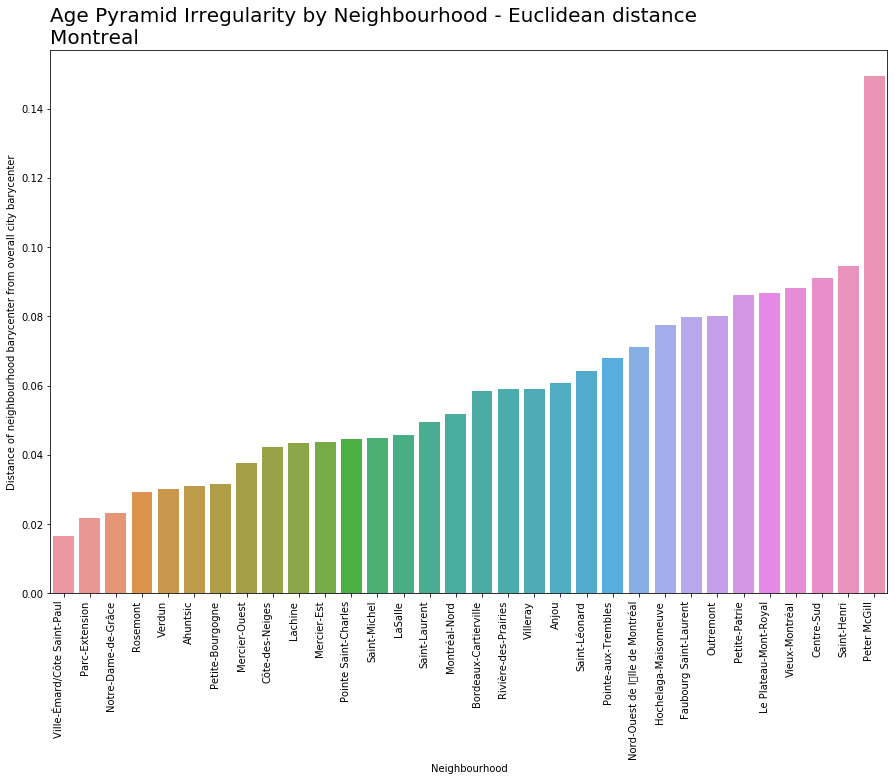

In [47]:
f=plt.figure(figsize=(15,10))


ax=sns.barplot(x="NOM" , y = "distToBarycenter" , data=dfBarycentersNeigh, order=dfBarycentersNeigh["NOM"]) 
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
ax.set(xlabel="Neighbourhood", 
       ylabel="Distance of neighbourhood barycenter from overall city barycenter"
       )
_= plt.title(label=f"Age Pyramid Irregularity by Neighbourhood - Euclidean distance\n{city}", loc="left", fontsize=20)

f.savefig( DATA_PATH /".."/ "Figures" / "ByNeigh" / f"euclBarPlotByNeigh_{city}.png")

## Plot the neighbouhood barycenters

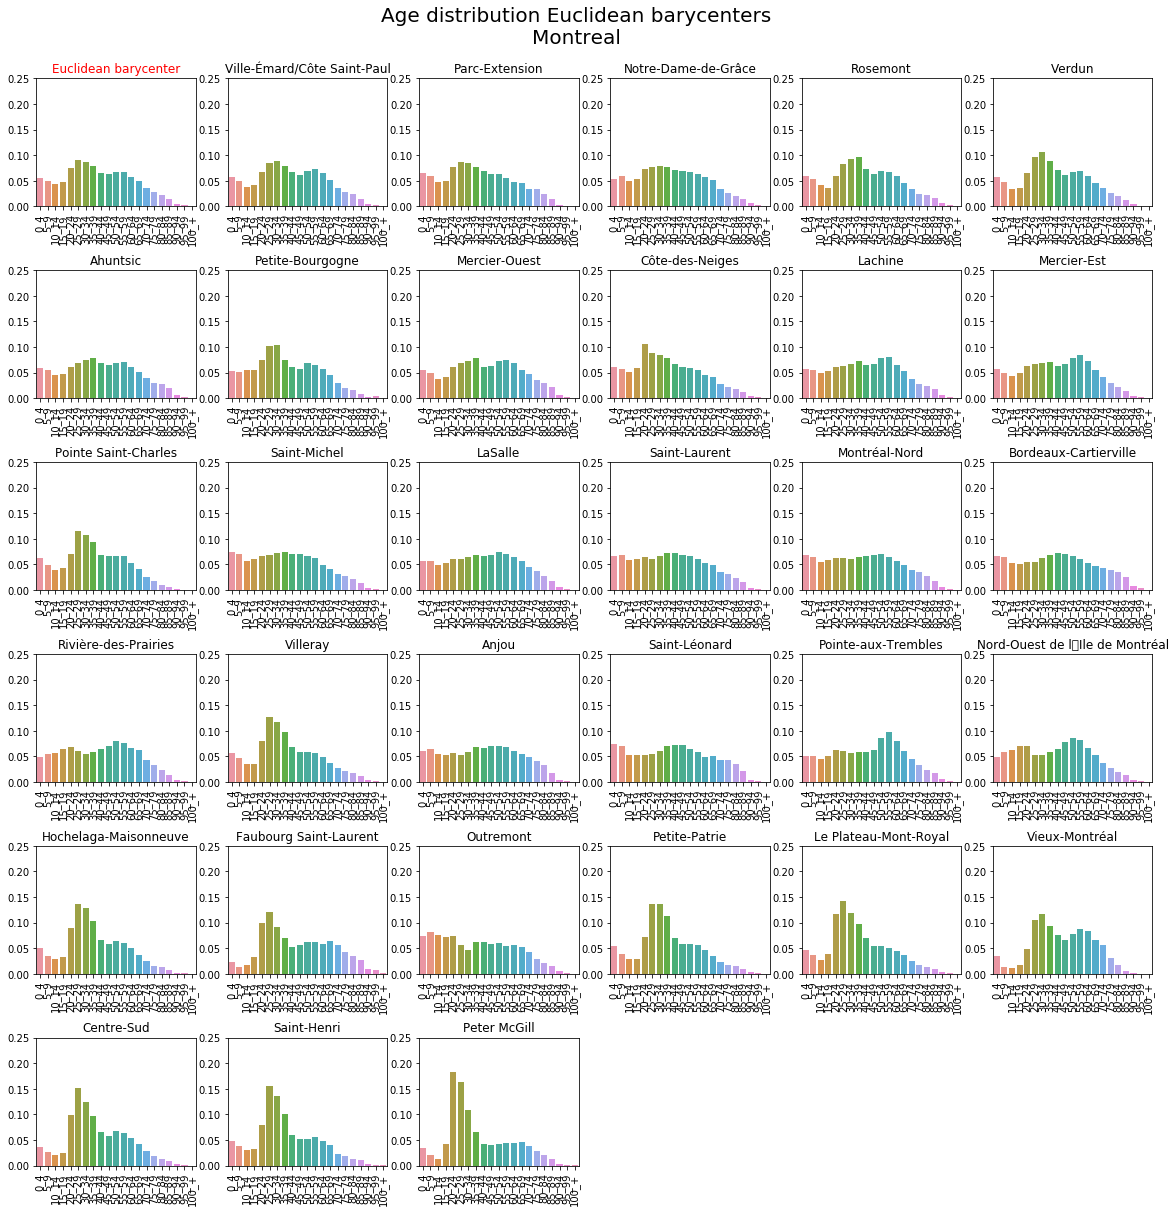

In [48]:
f=plt.figure(figsize=(20,20))
maxY=0.25

    
#The barycenter
sp=plt.subplot(6,6,1)
ax=sns.barplot(  x=LIST_AGE_COLS, y= EuclBaryGlobal )
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title(label="Euclidean barycenter", fontname="DejaVu Sans",color="red")
plt.ylim(0,maxY)

    
#Now the rest of the neighourhoods
for k,n in enumerate(dfBarycentersNeigh["NOM"].unique().sort_values()):
    dfSubset = dfBarycentersNeigh.loc[dfBarycentersNeigh["NOM"] == n,]
    sp=plt.subplot(6,6,k+1+1)
    ax=sns.barplot(  x=LIST_AGE_COLS, y= dfSubset[LIST_AGE_COLS].mean()  )
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.title(label=f"{n}")
    plt.ylim(0,maxY)



plt.subplots_adjust(hspace=0.5)
_ = plt.suptitle(f"Age distribution Euclidean barycenters\n{city}", fontsize=20 , y=0.93, x=0.5)

f.savefig( DATA_PATH /".."/ "Figures" / "ByNeigh" / f"euclAgePyramidBarycenterByNeigh_{city}.png")